# Alzheimer's Disease classification from anatomical MRI

# Exploring the classification of different imaging features using a random forest model
(Code deployed in Jupyter notebook using a PySpark kernel leveraging Apache Hadoop)

## Import analysis and plotting libraries

In [77]:
# "standard"
import numpy as np
import pandas as pd

# machine learning
# import pyspark
# from pyspark.sql import SparkSession
# import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Parallel computing
import dask
from dask.distributed import Client, progress
from dask.diagnostics import ProgressBar

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
from IPython.display import clear_output

In [ ]:
# import pyspark module
# spark = SparkSession.builder.appName("Brad's PySpark").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

## Load and format data

### load training data

In [ ]:
BASE_DIR = "C:/Users/bedelman/Documents\GitHub/Alzheimers-MRI-Classification/Alzheimer_MRI_Dataset/Data/"

'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train.head()

### Convert data to readable format

In [81]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Load and convert test data

In [83]:
test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Explore structure and visualization of the data

## Distribution of the datasets (are all classes represented equally?)

Text(0, 0.5, '# of images')

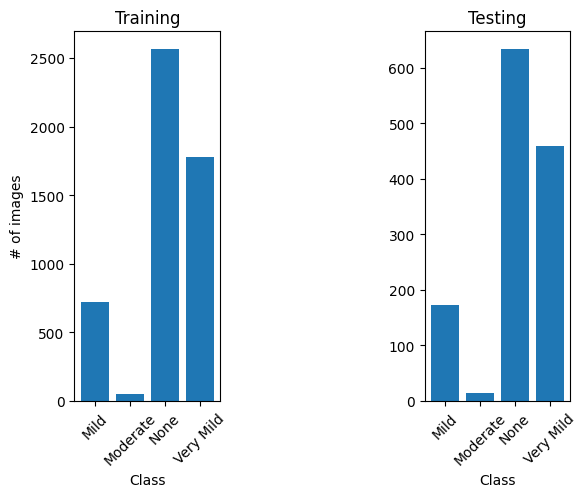

In [85]:
f, ax = plt.subplots(1,3)
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts = True)
ax[0].bar(unique, counts)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation = 45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

ax[1].axis('off')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts = True)
ax[2].bar(unique, counts)
ax[2].set_xticks(unique)
ax[2].set_xticklabels(Lab, rotation = 45)
ax[2].set_title('Testing')
ax[2].set_xlabel('Class')
ax[0].set_ylabel('# of images')

# An obvious imbalance across classes, but each class seems to be balanced across training/testing sets

## Visually inspect some of the data

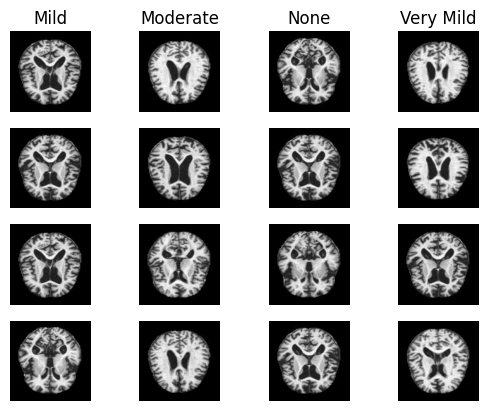

In [87]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

# Clearly, images show different slices within the brain, which may be a major confound...

## Feature engineering for visualization and classification

- raw pixel intensity X PCA
- histogram of oriented gradients
- segmented brain volume


## PCA on raw pixel data

Text(0, 0.5, 'Variance Explained')

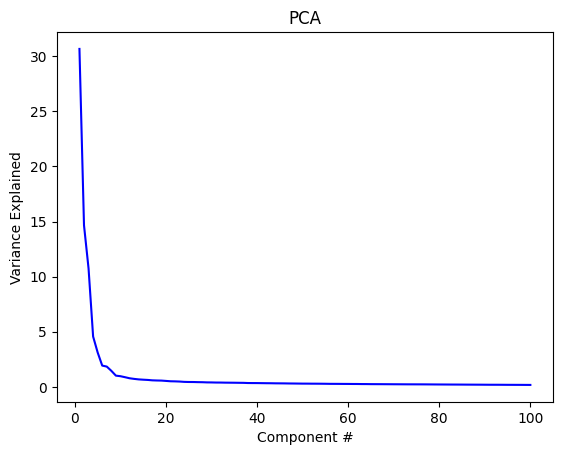

In [89]:
train_data = []
for i in range(len(train)):
    train_data.append(np.reshape(train.iloc[i].img_arr, (1, -1)))    
train_data = np.vstack(train_data[:])

# decompose with PCA and look at various metrics/info
pca = PCA(n_components = 100)
pca.fit(train_data)

plt.plot(np.linspace(1,100,100),pca.explained_variance_[:100]/sum(pca.explained_variance_[:100])*100,'b')
plt.title('PCA')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')

## Project training data into PCA space to visualize potential clustering

### Use first two PC's for simple visualization

Text(0, 0.5, 'PC 2')

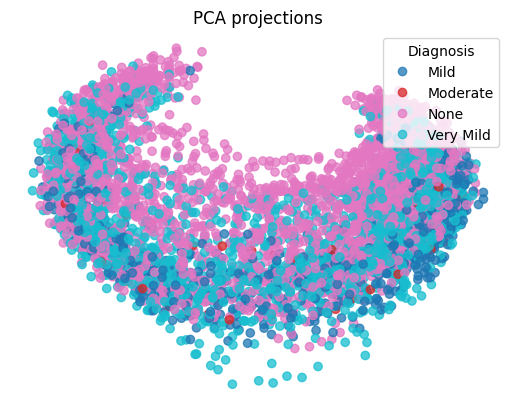

In [90]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_train = np.matmul(train_data, loadings[:,:2])

# plot first two PCs
s  = plt.scatter(load_train[:,0], load_train[:,1], c = train_lab_idx*2, cmap = 'tab10', alpha = 0.75)
handles, labels = s.legend_elements()
legend = plt.legend(handles = handles, labels = Lab, title = 'Diagnosis', loc = 'upper right')
plt.axis('off')
plt.title('PCA projections')
plt.xlabel('PC 1')
plt.ylabel('PC 2')


## Preliminary random forest classification using first two PCs

In [91]:
# Train random forest classifier and apply to test data
## for now again only with first two PCs

rf_1 = RandomForestClassifier()

# Train classifier
load_train = np.matmul(train_data, loadings[:,:2])
rf_1.fit(load_train, train_lab_idx)

# Properly format test data and extract same features (PC loadings)
test_data = []
for i in range(len(test)):
    test_data.append(np.reshape(test.iloc[i].img_arr, (1, -1)))    
test_data = np.vstack(test_data[:])

load_test = np.matmul(test_data, loadings[:,:2])

# Predict unseen data
predictions_1 = rf_1.predict(load_test)
test_lab_idx = np.asarray(test.iloc[:].label)

# compare predictions with test labels and compute accuracy
result = predictions_1 - test_lab_idx
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary,0)
acc = correct/test_lab_idx.shape[0]*100
print(acc)

# When using the top two PCs, we see a modest classification rate on the test set. 
## However, using two PC's here is arbitrary due to easy visualization purposes.
## We can also exmaine accuracy as a function of the number of PCs and visualize the PC loading maps to interpret the classification results

47.5


## Permutation testing on shuffled data as a control

### Parallelize time-consuming iterative processes (here with Dask)

In [92]:
client = Client(threads_per_worker = 5, n_workers = 2)
client

C:\Users\bedelman\Desktop\PySpark_proj\my_venv\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60442 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60442/status,
Dashboard: http://127.0.0.1:60442/status,Workers: 2
Total threads: 10,Total memory: 15.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60445,Workers: 2
Dashboard: http://127.0.0.1:60442/status,Total threads: 10
Started: Just now,Total memory: 15.59 GiB
Comm: tcp://127.0.0.1:60459,Total threads: 5
Dashboard: http://127.0.0.1:60460/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:60448,


## Shuffle data labels in the train set when building RF classifier to evaluate "chance" level 
### Do this a number of times to generate a sufficient null distribution

In [95]:
test_lab_idx = np.asarray(test.iloc[:].label)
train_lab_idx_shuffle = train_lab_idx
load_train = np.matmul(train_data, loadings[:,:2])

rng = np.random.default_rng()

def classification_RF_shuffle(load_train2, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    # Train classifier with new shuffled labels each iteration
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)

    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

# Parallelize lazy function to reduce computation time
## limit number of iterations in this function to account for computer memory limit
def iteration(load_train, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    acc_shuffle = []
    for i in range(100):
        acc_tmp = dask.delayed(classification_RF_shuffle)(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
        acc_shuffle.append(acc_tmp)
    
    # compute values
    acc_shuffle = dask.compute(*acc_shuffle)
    acc_shuffle = np.array([float(num) for num in acc_shuffle])
    return acc_shuffle

## Permute a sufficient number of times
### Not the most efficient way to do this, but again memory consideration on local machine

CPU times: total: 1min 11s
Wall time: 4min 47s


(30.0, 60.0)

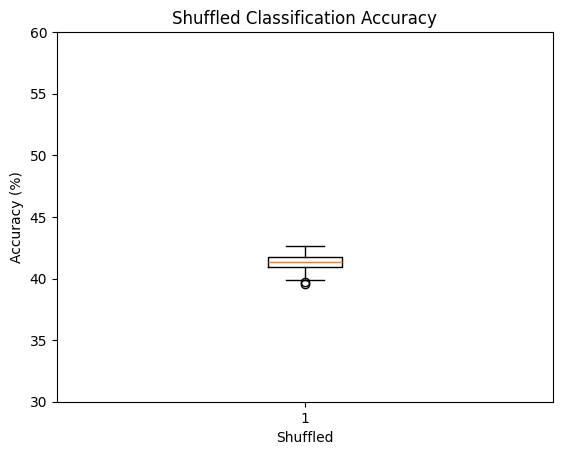

In [97]:
%%time

acc_shuffle_compile = []
for i in range(5):
    acc_tmp = iteration(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
    acc_shuffle_compile = np.concatenate((acc_shuffle_compile, acc_tmp), axis=0)
    clear_output(wait = True)

b = plt.boxplot(acc_shuffle_compile)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

In [100]:
%%time

# simple test to ensure that parallel processing is faster

# traditional for loop
acc_shuffle_nodask = []
for i in range(100):
    acc_tmp = classification_RF_shuffle(load_train, train_lab_idx, load_test, test_lab_idx)
    acc_shuffle_nodask.append(acc_tmp)

CPU times: total: 2min 43s
Wall time: 2min 43s


In [101]:
%%time

# dask parallelization
acc_shuffle_dask = []
for i in range(1):
    acc_tmp = iteration(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
    acc_shuffle_dask = np.concatenate((acc_shuffle_dask, acc_tmp), axis=0)
    clear_output(wait = True)

CPU times: total: 13.5 s
Wall time: 56.5 s


In [131]:
# Determine significance of previous classification accuracy

null_above_value = (acc_shuffle_compile > acc).sum()
p_value = null_above_value/np.size(acc_shuffle_compile,0)
print(p_value)

# We can see here that the classification accuracy is not sigificcantly different from chance with p-value > 0.05

0.0


## Now explore classification as a function of PCs

### Test set classification as a function of PCs

In [133]:
%%time

def classification_RF_PCs(num_pc, load_train, train_lab_idx, load_test, test_lab_idx):

    load_train = np.matmul(train_data, loadings[:,:num_pc])

    rf_1 = RandomForestClassifier()
    rf_1.fit(load_train, train_lab_idx)
    
    load_test = np.matmul(test_data, loadings[:,:num_pc])

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)
    
    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc


CPU times: total: 0 ns
Wall time: 0 ns


### Parallelize classification

In [218]:
acc_PC = []
for i in range(len(loadings)):
    acc_tmp = dask.delayed(classification_RF_PCs)(i, load_train, train_lab_idx, load_test, test_lab_idx)
    acc_PC.append(acc_tmp)

# # compute values
acc_PC = dask.compute(*acc_PC)
clear_output(wait = True)
acc_PC = np.array([float(num) for num in acc_PC])

# # plot accuracy as a function of PCs
# plt.plot(np.linspace(1,np.size(loadings,1)-1, np.size(loadings,1)-1), acc_PC, 'k')
# plt.title('Classification accuracy')
# plt.xlabel('Component #')
# plt.ylabel('Accuracy (%)')
# plt.ylim(30, 60)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2980253350.py, line 1)

In [ ]:
%%time

# Also permute train labels for each number of PCs

def classification_RF_PC_shuffle(num_pc, load_train, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    # Train classifier with new shuffled labels each iteration
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)

    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

# Parallelize lazy function 500 times
acc_PC_shuffle = []
for i in range(500):
    acc_tmp = dask.delayed(classification_RF_PC_shuffle)(i, load_train, train_lab_idx, load_test, test_lab_idx)
    acc_PC_shuffle.append(acc_tmp)

# compute values
acc_shuffle = dask.compute(*acc_shuffle)


b = plt.boxplot(acc_shuffle)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')

### Visualize PC's to identify spatial features that contribute to data variance and subsequent classification

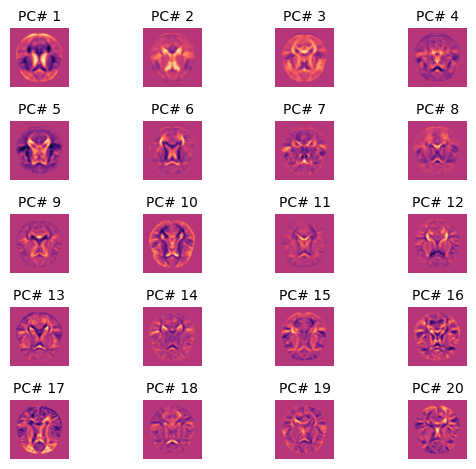

In [143]:
f, ax = plt.subplots(5,4)
lim = 20
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/4).astype(int)
    idx2 = np.fmod(ipc,4)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 10)
    plt.tight_layout()